# Problem Statement - Model that predicts the daily sales for Store X for test data set provided

## Part 2- Feature Engineering and Developing the Prediction Model

*********************************************************************************************************************

# TABLE OF CONTENTS

## 2.1 - Analysing the train data. Merging with store data
## 2.2 - Feature Engineering on train/store data
## 2.3 - VIF Calculation on train/store data
## 2.4 - Analysing the test with store data
## 2.5 - Feature Engineering on test/store data
## 2.6 - VIF Calculation on test/store data
## 2.7 - Scaling, Splitting train/store and test/store and feature selection for model
## 2.8 - Building and evaluating the Model and submissions
> - 2.8.1 Random Forest Regression
- 2.8.2 Lasso Regression
- 2.8.3 Ridge Regression
- 2.8.4 Catboost Regression

An Alternate Approach

- 2.8.5 Time series analysis using FBProphet

*********************************************************************************************************************

# Assimptions Used while doing the Analysis for this problem statement:
    
**Store name is X which operates in some country X**

### New Features added:

#### Date Features:
1. Year
2. Month
3. Week
4. Week of year
5. Day of week

#### Sales/Customers Features at store level
1. CompetitionOpenInMonths
2. Sales per day at store level
3. Customers at store level
4. Sales per customers per day at store level

#### Holidays Counter
1. SchoolHolidaysInPrevWeek                
2. SchoolHolidaysInWeek                    
3. StateHolidaysInPrevWeek                 
4. StateHolidaysInWeek                     
5. SchoolHolidaysInNextWeek                
6. StateHolidaysInNextWeek                 

#### Competition and Promotion related:
1. CompetitionOpenInMonths                 
2. PromoOpenInMonths                       
3. IsPromoMonth

#### Which features I could have added value but I was unable to add them due to either lack of some information or time limit

1. **State/Country and Weather Info** - I was not able to attach a specific country/state to the given data set. Though we have been given the information as to when the stores will be closed and I have extracted the dates as to when these stores are closed, still it is a tedious task to identify which country it is in which this store belongs. I looked up and found that it could be either Germany or even Austria as they share some of the common holidays. If I would have to know the country at least, I could have added the state and following the state I could have simply added the weather and that would have given some extra features like Temperature, Humidity, Wind Pressure, Snowfall, etc.

   I did some exploration of this and details are in the attached code :Statewise Info for stores.ipynb
   

2. **Sales Related** - I could have added features like last 60 days of sale per store, Median sales through the holiday period, and when a promo was in force with a range of 30,45,60 day period. I did implement the lagged sales but then removed it and proceeded with other features


### Missing values treated for

CompetitionDistance, 

CompetitionOpenSinceMonth, CompetitionOpenSinceYear,

Promo2SinceWeek,Promo2SinceYear,PromoInterval

*********************************************************************************************************************

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.2, color_codes=True)
from IPython.display import display
import datetime
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from termcolor import colored
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
os.getcwd()

'/Users/ishanbabbar/Documents/Python notebooks and projects/take_home_task_(3)'

## 2.1 Analysing the train data. Merging with store data

In [3]:
#Reading Train Data
df_train = pd.read_csv('train.csv', 
                       parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

In [4]:
display(df_train.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
print("****************************")
df_train.info()


****************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [6]:
#check for null values for train data
def find_missing(data):
    # number of missing values
    count_missing = data.isnull().sum().values
    # total records
    total = data.shape[0]
    ratio_missing = count_missing/total
    return pd.DataFrame(data={'missing_count':count_missing, 'missing_ratio':ratio_missing}, index=data.columns.values)
find_missing(df_train).head(10)

,missing_count,missing_ratio
Store,0,0.00
DayOfWeek,0,0.00
Date,0,0.00
Sales,0,0.00
Customers,0,0.00
Open,0,0.00
Promo,0,0.00
StateHoliday,0,0.00
SchoolHoliday,0,0.00


**No missing value can be seen in the train dataset. But still I would like to remove all data points where there were no sales at all be it store open or closed**

In [7]:
# Now let's deal with the situation where the store is closed or Open but there is no sale at all
# We dont' need to take into account such data points where no sale has happened at all
# So I will drop these points

df_train=df_train.drop(df_train[(df_train.Open == 0) & (df_train.Sales == 0)].index)
#Store open but not sales
df_train=df_train.drop(df_train[(df_train.Open != 0) & (df_train.Sales == 0)].index)
df_train = df_train.reset_index(drop=True)
print ("Updated Train dataset shape is {}".format(colored(df_train.shape,'red')))

Updated Train dataset shape is (844338, 9)


In [8]:
#A quick glance into all the unique values for all the important cols
display(df_train['DayOfWeek'].unique())
display(df_train['Open'].unique())
display(df_train['Promo'].unique())
display(df_train['SchoolHoliday'].unique())
display(df_train['StateHoliday'].unique())

array([5, 4, 3, 2, 1, 7, 6])

array([1])

array([1, 0])

array([1, 0])

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [9]:
#Let's check for descriptive stats now
display(df_train.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
Store,844338.00,558.42,321.73,1.00,280.00,558.00,837.00,1115.00
DayOfWeek,844338.00,3.52,1.72,1.00,2.00,3.00,5.00,7.00
Sales,844338.00,6955.96,3103.82,46.00,4859.00,6369.00,8360.00,41551.00
Customers,844338.00,762.78,401.19,8.00,519.00,676.00,893.00,7388.00
Open,844338.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00
Promo,844338.00,0.45,0.50,0.00,0.00,0.00,1.00,1.00
SchoolHoliday,844338.00,0.19,0.40,0.00,0.00,0.00,0.00,1.00


In [10]:
#Reading Store Data
df_store = pd.read_csv('store.csv')

In [11]:
display(df_store.head())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.00,9.00,2008.00,0,nan,nan,NaN
1,2,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,c,c,620.00,9.00,2009.00,0,nan,nan,NaN
4,5,a,a,29910.00,4.00,2015.00,0,nan,nan,NaN


In [12]:
print(f'Shape of train dataset is {df_store.shape}. \n')
print('*'*50 + '\n')

df_store.info()

Shape of train dataset is (1115, 10). 

**************************************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [13]:
#Missing value for store data
find_missing(df_store).head(15)

,missing_count,missing_ratio
Store,0,0.00
StoreType,0,0.00
Assortment,0,0.00
CompetitionDistance,3,0.00
CompetitionOpenSinceMonth,354,0.32
CompetitionOpenSinceYear,354,0.32
Promo2,0,0.00
Promo2SinceWeek,544,0.49
Promo2SinceYear,544,0.49
PromoInterval,544,0.49


**Missing values can be seen:**

1. CompetitionDistance, 
2. CompetitionOpenSinceMonth, CompetitionOpenSinceYear,
3. Promo2SinceWeek,Promo2SinceYear,PromoInterval

Lets Move forwrd to impute missing values

In [14]:
df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].median(), inplace = True)

In [15]:
#Imputing CompetitionOpenSinceMonth, CompetitionOpenSinceYear
#Have to be 0 as well since they are linked to CompetitionDistance.
# Another way to imput blanks here would be to create a multilabel classification problem and then identifying the month ans year for such blank fields.

df_store.CompetitionOpenSinceMonth.fillna(0, inplace = True)
df_store.CompetitionOpenSinceYear.fillna(0,inplace=True)

In [16]:
#Imputing Blanks for Promo2SinceWeek,Promo2SinceYear,PromoInterval
#Missing values comes from fields where Promo2=0 which means there are no continuous promotional activities for those stores.
#Have to be 0 as well since they are linked to Promo2.

df_store.Promo2SinceWeek.fillna(0,inplace=True)
df_store.Promo2SinceYear.fillna(0,inplace=True)
df_store.PromoInterval.fillna(0,inplace=True)

In [17]:
#Let's check for blanks again
find_missing(df_store).head(15)

,missing_count,missing_ratio
Store,0,0.00
StoreType,0,0.00
Assortment,0,0.00
CompetitionDistance,0,0.00
CompetitionOpenSinceMonth,0,0.00
CompetitionOpenSinceYear,0,0.00
Promo2,0,0.00
Promo2SinceWeek,0,0.00
Promo2SinceYear,0,0.00
PromoInterval,0,0.00


**No Missing Values in Store dataset now**

In [18]:
display(df_store.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
Store,1115.00,558.00,322.02,1.00,279.50,558.00,836.50,1115.00
CompetitionDistance,1115.00,5396.61,7654.51,20.00,720.00,2325.00,6875.00,75860.00
CompetitionOpenSinceMonth,1115.00,4.93,4.28,0.00,0.00,4.00,9.00,12.00
CompetitionOpenSinceYear,1115.00,1370.94,935.47,0.00,0.00,2006.00,2011.00,2015.00
Promo2,1115.00,0.51,0.50,0.00,0.00,1.00,1.00,1.00
Promo2SinceWeek,1115.00,12.08,15.54,0.00,0.00,1.00,22.00,50.00
Promo2SinceYear,1115.00,1030.24,1006.04,0.00,0.00,2009.00,2012.00,2015.00


#### Merging Train and Store Datasets

In [19]:
#Merging the dataset
df_train1 = pd.merge(df_train, df_store, on='Store')
df_train1 = df_train1.sort_values(['Date'],ascending = False)

## 2.2 Feature Engineering on train/store data. Adding new features that might be helpful

In [20]:
# #Sales Specific Features - Lagged Sales, EWM etc. Rest added features in the next code cell
# # Getting 30,90,180 and a full year lagged sale for a given store. The sales will only appear for a given store basis the lag

# new_feature_train_data = df_train1.set_index(['Date', 'Store']).sort_values('Date')


# #Getting 60 days lagged sales
# new_column = new_feature_train_data.groupby('Store')['Sales'].shift(60)
# new_feature_train_data['Sales_60_lag'] = new_column
# new_feature_train_data.reset_index(inplace=True)

# #Getting 90 days lagged sales
# new_column = new_feature_train_data.groupby('Store')['Sales'].shift(90)
# new_feature_train_data['Sales_90_lag'] = new_column

# #Getting 180 days lagged sales
# new_column = new_feature_train_data.groupby('Store')['Sales'].shift(180)
# new_feature_train_data['Sales_180_lag'] = new_column

# #Getting 365 days lagged sales
# new_column = new_feature_train_data.groupby('Store')['Sales'].shift(365)
# new_feature_train_data['Sales_365_lag'] = new_column

# # new_feature_train_data['EWM_15'] = new_feature_train_data.groupby(['Store'])['Sales_60_lag'].transform(lambda x: x.ewm(span = 15, min_periods = 15).mean()).values
# # new_feature_train_data['EWM_30'] = new_feature_train_data.groupby(['Store'])['Sales_60_lag'].transform(lambda x: x.ewm(span = 30, min_periods = 30).mean()).values
# # new_feature_train_data['EWM_45'] = new_feature_train_data.groupby(['Store'])['Sales_60_lag'].transform(lambda x: x.ewm(span = 45, min_periods = 45).mean()).values


store_level_sales = df_train1.groupby([df_train1['Store']])['Sales'].sum()
store_level_customers = df_train1.groupby([df_train1['Store']])['Customers'].sum()
store_level_open = df_train1.groupby([df_train1['Store']])['Open'].count()

# Calculate sales per day, customers per day and sales per customers per day
store_data_sales_per_day = store_level_sales/store_level_open
store_data_customers_per_day = store_level_customers / store_level_open
store_data_sales_per_customer_per_day = store_data_sales_per_day / store_data_customers_per_day

#Saving the above values in a dictionary so that they can be mapped to the dataframe both train_store and test_store.
sales_per_day_dict = dict(store_data_sales_per_day)
customers_per_day_dict = dict(store_data_customers_per_day)
sales_per_customers_per_day_dict = dict(store_data_sales_per_customer_per_day)

df_train1['sales_per_Day_at_store'] = df_train1['Store'].map(sales_per_day_dict)
df_train1['Customers_per_day_at_store'] = df_train1['Store'].map(customers_per_day_dict)
df_train1['Sales_Per_Customers_Per_Day_at_store'] = df_train1['Store'].map(sales_per_customers_per_day_dict)

del df_train1['Customers']

In [21]:
#Lets Add some new features to our merged dataset
def add_new_features(data):
    
    #mappings dicts
    month_ind = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    #Date Features
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
        
    #School and State Holidays related features
    def school_holidays(x):
        if x.sum()>6:
            return 6
        else:
            return x.sum()
        
    data['StateHolidayBinary'] = data['StateHoliday'].apply(lambda x:0 if x==0 else 1)
    #Number of School Holidays in last 7 days
    data['SchoolHolidaysInPrevWeek'] = data.groupby(['Store'])['SchoolHoliday'].transform(lambda x:x.rolling(7).sum()).values

    #Number of School Holidays in current week
    data['SchoolHolidaysInWeek'] = data.groupby(['Year','WeekOfYear','Store'])['SchoolHoliday'].transform(school_holidays).values

    #Number of State Holidays in last 7 days
    data['StateHolidaysInPrevWeek'] = data.groupby(['Store'])['StateHolidayBinary'].transform(lambda x:x.rolling(7).sum()).values

    #Number of state holidays in current week for a particular store
    data['StateHolidaysInWeek'] = data.groupby(['Year','WeekOfYear','Store'])['StateHolidayBinary'].transform(sum).values
    data = data.sort_values('Date', ascending= False)

    #Number of School Holidays in next 7 days
    data['SchoolHolidaysInNextWeek'] = data.groupby('Store', group_keys=False)['SchoolHoliday'].transform(lambda x:x.rolling(7).sum())
    #Number of State Holidays in next 7 days
    data['StateHolidaysInNextWeek'] = data.groupby('Store', group_keys=False)['StateHolidayBinary'].transform(lambda x:x.rolling(7).sum())

    #difference of months since the competietion was open
    data['CompetitionOpenInMonths'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + (data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpenInMonths'] = data['CompetitionOpenInMonths'].apply(lambda x: x if x > 0 else 0)
    
    #Promo Open time in months
    data['PromoOpenInMonths'] = 12 * (data['Year'] - data['Promo2SinceYear']) + (data['WeekOfYear'] - data['Promo2SinceWeek']) / 4.0

    #Adding a feature to showw if a promo is live in amonth or not
    data['month_names'] = data.Month.map(month_ind)
    def is_promo_month(row):
        if isinstance(row['PromoInterval'],str) and (row['month_names'] in row['PromoInterval']) and (row['PromoOpenInMonths']>0):
            return 1
        else:
            return 0
        
    data['IsPromoMonth'] =  data.apply(lambda row: is_promo_month(row),axis=1)    
    #treating categorical features
    data["is_holiday_state"] = data['StateHoliday'].map({"0": 0, "a": 1, "b": 1, "c": 1})
    #dummies for the cat features
    data=data.drop(['StateHoliday','month_names','PromoInterval','StateHolidayBinary'],1)
    data=pd.get_dummies(data, columns=['Assortment', 'StoreType'],prefix=['is_Assortment', 'is_StoreType'])
    data.fillna(0,inplace=True)
    
    return data

In [22]:
train_comp_v1 = add_new_features(df_train1)

In [23]:
print ("Merged dataset with additional features. The shape is {}".format(colored(train_comp_v1.shape,'red')))
print('*'*50 + '\n')
train_comp_v1.info()

Merged dataset with additional features. The shape is (844338, 37)
**************************************************

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 64386
Data columns (total 37 columns):
Store                                   844338 non-null int64
DayOfWeek                               844338 non-null int64
Date                                    844338 non-null datetime64[ns]
Sales                                   844338 non-null int64
Open                                    844338 non-null int64
Promo                                   844338 non-null int64
SchoolHoliday                           844338 non-null int64
CompetitionDistance                     844338 non-null float64
CompetitionOpenSinceMonth               844338 non-null float64
CompetitionOpenSinceYear                844338 non-null float64
Promo2                                  844338 non-null int64
Promo2SinceWeek                         844338 non-null float64
Promo2Sinc

In [24]:
find_missing(train_comp_v1).head(37)

,missing_count,missing_ratio
Store,0,0.00
DayOfWeek,0,0.00
Date,0,0.00
Sales,0,0.00
Open,0,0.00
Promo,0,0.00
SchoolHoliday,0,0.00
CompetitionDistance,0,0.00
CompetitionOpenSinceMonth,0,0.00
CompetitionOpenSinceYear,0,0.00


In [25]:
#create a seperate dataframe for the dummies as we are now going to calculate VIF and dummies should not be in there.
#Dummies will add uncessaery noise to the data
#We will merge these datasets again post VIF calculation

train_store_dummies = train_comp_v1[['is_Assortment_a','is_Assortment_b','is_Assortment_c',
                                    'is_StoreType_a','is_StoreType_b','is_StoreType_c','is_StoreType_d']]

train_comp_v1 = train_comp_v1.drop(['is_Assortment_a','is_Assortment_b','is_Assortment_c',
                                    'is_StoreType_a','is_StoreType_b','is_StoreType_c','is_StoreType_d'],1)


In [26]:
#VIF Calculation
#Dropping Sales and Date col for VIF calculation

VIF_X = train_comp_v1.drop(['Date','Sales','Open'], axis=1)
VIF_X.head()

,Store,DayOfWeek,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,...,SchoolHolidaysInPrevWeek,SchoolHolidaysInWeek,StateHolidaysInPrevWeek,StateHolidaysInWeek,SchoolHolidaysInNextWeek,StateHolidaysInNextWeek,CompetitionOpenInMonths,PromoOpenInMonths,IsPromoMonth,is_holiday_state
0,1,4,1,1,1270.00,9.00,2008.00,0,0.00,0.00,...,0.00,5,0.00,5,0.00,0.00,82.00,24187.75,0,0.00
370603,491,4,1,1,4680.00,0.00,0.00,1,22.00,2012.00,...,0.00,2,0.00,5,0.00,0.00,24187.00,38.25,0,0.00
596339,790,4,1,1,9070.00,12.00,2003.00,0,0.00,0.00,...,0.00,5,0.00,5,0.00,0.00,139.00,24187.75,0,0.00
369981,490,4,1,0,660.00,4.00,2013.00,1,40.00,2014.00,...,0.00,0,0.00,5,0.00,0.00,27.00,9.75,1,0.00
397784,527,4,1,1,5830.00,4.00,2008.00,0,0.00,0.00,...,0.00,5,0.00,5,0.00,0.00,87.00,24187.75,0,0.00


## 2.3 VIF Calculation on train/store data

In [27]:
# Lets calculate Variance Inflation factor now
# This will help us to remove features with high multicollinearity
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [28]:
calc_vif(VIF_X)

,variables,VIF
0,Store,4.04
1,DayOfWeek,3.67
2,Promo,2.05
3,SchoolHoliday,5.60
4,CompetitionDistance,1.67
5,CompetitionOpenSinceMonth,9.92
6,CompetitionOpenSinceYear,31284138.57
7,Promo2,1619278.77
8,Promo2SinceWeek,inf
9,Promo2SinceYear,inf


In [29]:
#Following an iterative approach and dropping some variables right away to reduceVIF
VIF_X = VIF_X.drop(['Promo2SinceYear','WeekOfYear','CompetitionOpenSinceYear','Day','Promo2',
                    'Promo2SinceWeek','Year','CompetitionOpenSinceMonth',
                    'StateHolidaysInNextWeek','SchoolHolidaysInNextWeek'], axis=1)
calc_vif(VIF_X)

,variables,VIF
0,Store,3.89
1,DayOfWeek,3.56
2,Promo,1.96
3,SchoolHoliday,5.59
4,CompetitionDistance,1.66
5,sales_per_Day_at_store,60.24
6,Customers_per_day_at_store,35.26
7,Sales_Per_Customers_Per_Day_at_store,26.49
8,Month,4.22
9,SchoolHolidaysInPrevWeek,3.65


In [30]:
#concatenate the two tables from where we dropped the dummies vs the original data again and then drop all the features 
train_store_clean = pd.concat([train_comp_v1,train_store_dummies],axis=1)
train_store_clean.shape

(844338, 37)

In [31]:
#Createing final dataset to be pushed to model pipeline
train_store_features =train_store_clean.drop(['Promo2SinceYear','WeekOfYear',
                                              'CompetitionOpenSinceYear','Day','Promo2',
                                              'Promo2SinceWeek','Year','CompetitionOpenSinceMonth',
                                              'StateHolidaysInNextWeek','SchoolHolidaysInNextWeek'],axis=1)
train_store_target = train_store_clean['Sales']

In [35]:
train_store_features.head()

,Store,DayOfWeek,Date,Sales,Open,Promo,SchoolHoliday,CompetitionDistance,sales_per_Day_at_store,Customers_per_day_at_store,...,PromoOpenInMonths,IsPromoMonth,is_holiday_state,is_Assortment_a,is_Assortment_b,is_Assortment_c,is_StoreType_a,is_StoreType_b,is_StoreType_c,is_StoreType_d
0,1,4,2015-07-31,5263,1,1,1,1270.00,4759.10,564.05,...,24187.75,0,0.00,1,0,0,0,0,1,0
370603,491,4,2015-07-31,9951,1,1,1,4680.00,6746.46,527.29,...,38.25,0,0.00,0,0,1,0,0,0,1
596339,790,4,2015-07-31,10141,1,1,1,9070.00,7453.02,682.36,...,24187.75,0,0.00,0,0,1,0,0,0,1
369981,490,4,2015-07-31,9184,1,1,0,660.00,8249.73,1063.72,...,9.75,1,0.00,1,0,0,1,0,0,0
397784,527,4,2015-07-31,14510,1,1,1,5830.00,10734.69,1000.49,...,24187.75,0,0.00,0,0,1,0,0,0,1


In [36]:
train_store_target.head()

0          5263
370603     9951
596339    10141
369981     9184
397784    14510
Name: Sales, dtype: int64

## 2.4 - Analysing the test with store data

In [ ]:
#applying all of the feature engineering and other modifications to make test and train datasets consistent

In [37]:
#Reading test data
df_test = pd.read_csv('test.csv', 
                        parse_dates=['Date'],
                        date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

In [38]:
find_missing(df_test).head(25)

,missing_count,missing_ratio
Id,0,0.00
Store,0,0.00
DayOfWeek,0,0.00
Date,0,0.00
Open,11,0.00
Promo,0,0.00
StateHoliday,0,0.00
SchoolHoliday,0,0.00


In [39]:
#imputing blanks for open column
df_test.fillna(1, inplace = True) #11rows with Nans decided to leave them open since its one store 622 which is usually open

In [40]:
find_missing(df_test).head(25)

,missing_count,missing_ratio
Id,0,0.00
Store,0,0.00
DayOfWeek,0,0.00
Date,0,0.00
Open,0,0.00
Promo,0,0.00
StateHoliday,0,0.00
SchoolHoliday,0,0.00


In [41]:
#merge store and test data
df_test_store = pd.merge(df_test, df_store,how='left', on='Store')
df_test_store = df_test_store.sort_values(['Date'],ascending = False)

In [42]:
print ("Test and Store merged dataset has Shape {}".format(colored(df_test_store.shape,'red')))
print('*'*50 + '\n')
df_test_store.info()

Test and Store merged dataset has Shape (41088, 17)
**************************************************

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
Id                           41088 non-null int64
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Date                         41088 non-null datetime64[ns]
Open                         41088 non-null float64
Promo                        41088 non-null int64
StateHoliday                 41088 non-null object
SchoolHoliday                41088 non-null int64
StoreType                    41088 non-null object
Assortment                   41088 non-null object
CompetitionDistance          41088 non-null float64
CompetitionOpenSinceMonth    41088 non-null float64
CompetitionOpenSinceYear     41088 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              41088 non-null float64
Promo2SinceYear

In [43]:
#adapting the same dictionaries from the train set to appply store level info to test set as well
df_test_store['sales_per_Day_at_store'] = df_test_store['Store'].map(sales_per_day_dict)
df_test_store['Customers_per_day_at_store'] = df_test_store['Store'].map(customers_per_day_dict)
df_test_store['Sales_Per_Customers_Per_Day_at_store'] = df_test_store['Store'].map(sales_per_customers_per_day_dict)

In [44]:
df_test_store.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,sales_per_Day_at_store,Customers_per_day_at_store,Sales_Per_Customers_Per_Day_at_store
0,1,1,4,2015-09-17,1.00,1,0,0,c,a,1270.00,9.00,2008.00,0,0.00,0.00,0,4759.10,564.05,8.44
563,564,728,4,2015-09-17,1.00,1,0,0,d,a,13990.00,0.00,0.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct",5245.71,458.06,11.45
565,566,731,4,2015-09-17,1.00,1,0,0,a,a,15270.00,0.00,0.00,1,10.00,2014.00,"Jan,Apr,Jul,Oct",9249.23,950.92,9.73
566,567,732,4,2015-09-17,1.00,1,0,0,a,c,35280.00,0.00,0.00,0,0.00,0.00,0,5816.44,661.46,8.79
567,568,733,4,2015-09-17,1.00,1,0,0,b,b,860.00,10.00,1999.00,0,0.00,0.00,0,14933.29,3403.46,4.39


## 2.5 - Feature Engineering on test/store data

In [45]:
#using the same add_new_feature
test_comp_v1 = add_new_features(df_test_store)

In [46]:
print ("Shape with new features for Test and Store merged Dataset {}".format(colored(test_comp_v1.shape,'red')))
print('*'*50 + '\n')
test_comp_v1.info()

Shape with new features for Test and Store merged Dataset (41088, 37)
**************************************************

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 37 columns):
Id                                      41088 non-null int64
Store                                   41088 non-null int64
DayOfWeek                               41088 non-null int64
Date                                    41088 non-null datetime64[ns]
Open                                    41088 non-null float64
Promo                                   41088 non-null int64
SchoolHoliday                           41088 non-null int64
CompetitionDistance                     41088 non-null float64
CompetitionOpenSinceMonth               41088 non-null float64
CompetitionOpenSinceYear                41088 non-null float64
Promo2                                  41088 non-null int64
Promo2SinceWeek                         41088 non-null float64
Promo2SinceYear   

In [47]:
find_missing(test_comp_v1).head(37)

,missing_count,missing_ratio
Id,0,0.00
Store,0,0.00
DayOfWeek,0,0.00
Date,0,0.00
Open,0,0.00
Promo,0,0.00
SchoolHoliday,0,0.00
CompetitionDistance,0,0.00
CompetitionOpenSinceMonth,0,0.00
CompetitionOpenSinceYear,0,0.00


In [48]:
test_store_dummies = test_comp_v1[['is_Assortment_a','is_Assortment_b','is_Assortment_c',
                                    'is_StoreType_a','is_StoreType_b','is_StoreType_c','is_StoreType_d']]

test_comp_v1 = test_comp_v1.drop(['is_Assortment_a','is_Assortment_b','is_Assortment_c',
                                    'is_StoreType_a','is_StoreType_b','is_StoreType_c','is_StoreType_d'],1)


## 2.6 - VIF Calculation on test/store data

In [49]:
#VIF Calculation
#Dropping features that are not required
VIF_X_test = test_comp_v1.drop(['Id','Date'],1)

In [50]:
calc_vif(VIF_X_test)

,variables,VIF
0,Store,1.01
1,DayOfWeek,inf
2,Open,1.68
3,Promo,1.42
4,SchoolHoliday,3.70
5,CompetitionDistance,1.13
6,CompetitionOpenSinceMonth,inf
7,CompetitionOpenSinceYear,inf
8,Promo2,636368.69
9,Promo2SinceWeek,inf


In [51]:
#Following an iterative approach and dropping some variables right away to reduceVIF
VIF_X_test = VIF_X_test.drop(['Promo2SinceYear','WeekOfYear','CompetitionOpenSinceYear','Day','Promo2',
                    'Promo2SinceWeek','Year','CompetitionOpenSinceMonth',
                    'StateHolidaysInNextWeek','SchoolHolidaysInNextWeek','Open'], axis=1)
calc_vif(VIF_X_test)

,variables,VIF
0,Store,4.03
1,DayOfWeek,5.16
2,Promo,2.22
3,SchoolHoliday,6.54
4,CompetitionDistance,1.68
5,sales_per_Day_at_store,83.02
6,Customers_per_day_at_store,57.35
7,Sales_Per_Customers_Per_Day_at_store,91.08
8,Month,105.44
9,SchoolHolidaysInPrevWeek,12.06


In [52]:
#concatenate the two tables from where we dropped the dummies vs the original data again and then drop all the features 
test_store_clean = pd.concat([test_comp_v1,test_store_dummies],axis=1)
test_store_clean.shape

(41088, 37)

In [53]:
#Createing final dataset to be pushed to model pipeline
test_store_features =test_store_clean.drop(['Promo2SinceYear','WeekOfYear',
                                            'CompetitionOpenSinceYear','Day','Promo2',
                                            'Promo2SinceWeek','Year','CompetitionOpenSinceMonth',
                                            'StateHolidaysInNextWeek','SchoolHolidaysInNextWeek','Open'],axis=1)

In [54]:
test_store_features.head()

,Id,Store,DayOfWeek,Date,Promo,SchoolHoliday,CompetitionDistance,sales_per_Day_at_store,Customers_per_day_at_store,Sales_Per_Customers_Per_Day_at_store,...,PromoOpenInMonths,IsPromoMonth,is_holiday_state,is_Assortment_a,is_Assortment_b,is_Assortment_c,is_StoreType_a,is_StoreType_b,is_StoreType_c,is_StoreType_d
0,1,1,3,2015-09-17,1,0,1270.00,4759.10,564.05,8.44,...,24189.50,0,0,1,0,0,0,0,1,0
26,27,36,3,2015-09-17,1,0,540.00,9363.64,1090.32,8.59,...,11.50,0,0,0,0,1,1,0,0,0
25,26,35,3,2015-09-17,1,0,7660.00,9703.07,729.65,13.30,...,45.25,0,0,0,0,1,0,0,0,1
427,428,553,3,2015-09-17,1,0,3040.00,7038.60,638.75,11.02,...,66.25,0,0,1,0,0,0,0,1,0
3,4,8,3,2015-09-17,1,0,7520.00,5539.36,658.20,8.42,...,24189.50,0,0,1,0,0,1,0,0,0


## 2.7 Scaling, Splitting train/store and test/store and feature selection for model
! No encoding is needed as the entire dataframe is in numeric format

In [55]:
#Before going for split and scaling, we need to make both the datasets, train and test of equal size
#As we shall be using the same scalar on top of the test set as we used on the train set
#Feature Selection
train_store_features = train_store_features[['Store','DayOfWeek','Promo','SchoolHoliday','CompetitionDistance',
                                             'sales_per_Day_at_store','Customers_per_day_at_store','Sales_Per_Customers_Per_Day_at_store',
                                             'Month','SchoolHolidaysInPrevWeek','SchoolHolidaysInWeek','StateHolidaysInPrevWeek',
                                             'StateHolidaysInWeek','CompetitionOpenInMonths','PromoOpenInMonths',
                                             'IsPromoMonth','is_holiday_state','is_Assortment_a',
                                             'is_Assortment_b','is_Assortment_c','is_StoreType_a',
                                             'is_StoreType_b','is_StoreType_c','is_StoreType_d']]

test_store_features = test_store_features[['Store','DayOfWeek','Promo','SchoolHoliday','CompetitionDistance',
                                             'sales_per_Day_at_store','Customers_per_day_at_store','Sales_Per_Customers_Per_Day_at_store',
                                             'Month','SchoolHolidaysInPrevWeek','SchoolHolidaysInWeek','StateHolidaysInPrevWeek',
                                             'StateHolidaysInWeek','CompetitionOpenInMonths','PromoOpenInMonths',
                                             'IsPromoMonth','is_holiday_state','is_Assortment_a',
                                             'is_Assortment_b','is_Assortment_c','is_StoreType_a',
                                             'is_StoreType_b','is_StoreType_c','is_StoreType_d']]

In [56]:
train_store_features = train_store_features.astype('float64')
test_store_features = test_store_features.astype('float64')

In [59]:
# We can use here a MinMax Scalar to scale this dataet with a range of 0 to 1
#Split the data before scaling as it is a better approach
X_train, X_test, y_train, y_test = train_test_split(train_store_features,
                                                    train_store_target,
                                                    test_size=0.2,
                                                    random_state=42)  
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)


Number transactions X_train dataset:  (675470, 24)
Number transactions y_train dataset:  (675470,)
Number transactions X_test dataset:  (168868, 24)
Number transactions y_test dataset:  (168868,)


In [60]:
#Scale the datasets
from sklearn.preprocessing import MinMaxScaler,RobustScaler
mm_scalar = MinMaxScaler(feature_range=(0,1))
scaled_X_train = mm_scalar.fit_transform(X_train)
scaled_X_test = mm_scalar.transform(X_test)
scaled_test_store_features = mm_scalar.transform(test_store_features)

**END of Data preprocessing, Scaling and feature selection.**

All of the above will be useful while doing the second part model building using Regression techniques post performing Time series analysis using FB Prophet

# 2.8 Building the Model 

1. Random Forest Regressor
2. Lasso Regression
3. Ridge Regression
4. Catboost Regressor
5. TIme Series using FBProphet - An alternative approach

# Regression Pipeline

**Model Evaluation/ Metric: RMSPE for Random Forest, Lasso and Ridge Regression and RMSE for Catboost Regressor**

### 2.8.1 Random Forest Regression

Random forest is a bagging technique and not a boosting technique. The trees in random forests are run in parallel. There is no interaction between these trees while building the trees.
It operates by constructing a multitude of decision trees at training time and outputting the class that is the mean prediction (regression) of the individual trees.

In [61]:
#Defining another important metric that can give better results
#as we are using rmspe as the metric, I will be using log(sales)
def rmspe(y, yhat):
    rmspe = np.sqrt(np.mean(((y - yhat)/y)**2))
    return rmspe

In [64]:
#RF Model
tscv = TimeSeriesSplit(n_splits=3) #Number of splits. Must be at least 2
rf_model = RandomForestRegressor(max_features = 0.5)
parameters =  {'max_depth':[10,20,30,40], 
               'n_estimators':[20,30,40,50]}
#from 5 to 10 folds only 1% of error has reduced on te test set. So to save time, I will keep it to 5 folds
rf_clf = RandomizedSearchCV(rf_model, parameters, cv=tscv, scoring='neg_mean_squared_error', verbose=2, return_train_score=True, n_iter=10, n_jobs = -1)
rf_clf.fit(scaled_X_train,np.log1p(y_train))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=RandomForestRegressor(max_features=0.5), n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40],
                                        'n_estimators': [20, 30, 40, 50]},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=2)

In [65]:
print("best params: " + str(rf_clf.best_estimator_))
print("best params: " + str(rf_clf.best_params_))

{'n_estimators': 50, 'max_depth': 20}

In [126]:
rf_model = RandomForestRegressor(max_depth = 20, n_estimators = 50, verbose=1, n_jobs = 3, max_features=0.5)
rf_model.fit(scaled_X_train,np.log1p(y_train))

rf_train_preds = rf_model.predict(scaled_X_train)
rf_preds = rf_model.predict(scaled_X_test)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  1.3min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    6.4s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    7.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.6s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.8s finished


In [127]:
print(f'Metric score on train set is {rmspe(y_train, np.expm1(rf_train_preds))}')
print(f'Metric score on test set is {rmspe(y_test, np.expm1(rf_preds))}')

Metric score on train set is 0.0859890349128187
Metric score on test set is 0.13447073999492995


In [128]:
#Prepraing submission
preds_val = rf_model.predict(scaled_test_store_features)
pred_sales= np.expm1(preds_val)
pred_sales_df= pd.DataFrame({'Id': df_test_store['Id'], 
                             'Sales':pred_sales })
pred_sales_df.to_csv("submission_RF.csv", index = False)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.3s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.4s finished


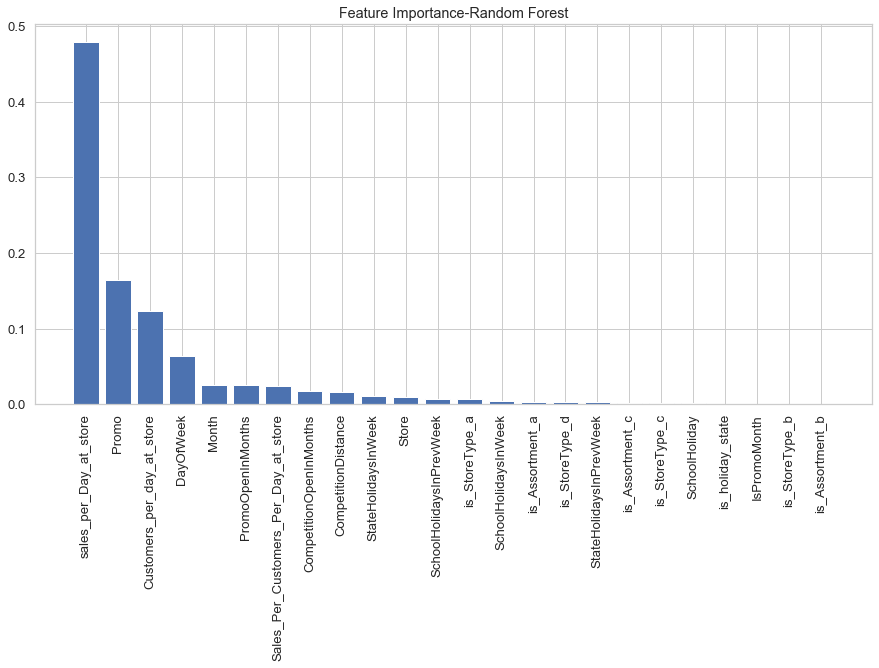

In [136]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X_train.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances
plt.figure(figsize=(15, 7)) # Create plot
plt.title("Feature Importance-Random Forest") # Create plot title
plt.bar(range(X_train.shape[1]), importances[indices]) # Add bars
plt.xticks(range(X_train.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot

### 2.8.2 Lasso Regression

Lasso regression is a common modeling technique to do regularization. The math behind it is pretty interesting, but practically, what you need to know is that Lasso regression comes with a parameter, alpha, and the higher the alpha, the most feature coefficients are zero.

That is, when alpha is 0, Lasso regression produces the same coefficients as a linear regression. When alpha is very very large, all coefficients are zero.

In [70]:
#Lasso Regression
lasso_reg = Lasso()
parameters = {'alpha':[10**-5, 10**-4, 10**-3, 10**-2, 0.1, 1, 10, 10**2, 10**3, 10**4, 10**5]}
lasso_clf = GridSearchCV(lasso_reg, parameters, cv=tscv, scoring='neg_mean_squared_error', verbose = 2, return_train_score=True, n_jobs = -1)
lasso_clf.fit(scaled_X_train,y_train)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                   1000, 10000, 100000]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [71]:
print("best params: " + str(lasso_clf.best_estimator_))
print("best params: " + str(lasso_clf.best_params_))

{'alpha': 0.1}

In [72]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(scaled_X_train,np.log1p(y_train))

lasso_train_preds = lasso_reg.predict(scaled_X_train)
lasso_preds = lasso_reg.predict(scaled_X_test)

In [74]:
print(f'Metric score on train set is {rmspe(y_train, np.expm1(lasso_train_preds))}')
print(f'Metric score on test set is {rmspe(y_test, np.expm1(lasso_preds))}')

best params: Lasso(alpha=0.1)
best params: {'alpha': 0.1}
Metric score on train set is 0.5635937711661247
Metric score on test set is 0.5403884972365106


### 2.8.3 Ridge Regression

Ridge regression is an extension of linear regression. It’s basically a regularized linear regression model.

Ridge Regression is a technique for analyzing multiple regression data that suffer from multicollinearity. When multicollinearity occurs, least squares estimates are unbiased, but their variances are large so they may be far from the true value

The hyperparameter, α,lets us control how much we penalize the coefficients, with higher values of α creating simpler modelers. The ideal value of α should be tuned like any other hyperparameter. In scikit-learn, α is set using the alpha parameter.

In [75]:
#Ridge Regression
ridge_reg = Ridge()
ridge_parameters = {'alpha':[10**-5, 10**-4, 10**-3, 10**-2, 0.1, 1, 10, 10**2, 10**3, 10**4, 10**5]}
ridge_clf = GridSearchCV(ridge_reg, ridge_parameters, cv=tscv, scoring='neg_mean_squared_error', verbose = 2, return_train_score=True, n_jobs = -1)
ridge_clf.fit(scaled_X_train,y_train)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                   1000, 10000, 100000]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [76]:
print("best params: " + str(ridge_clf.best_estimator_))
print("best params: " + str(ridge_clf.best_params_))

best params: Ridge(alpha=1)
best params: {'alpha': 1}


In [77]:
ridge_reg = Ridge(alpha=1)
ridge_reg.fit(scaled_X_train,np.log1p(y_train))

ridge_train_preds = ridge_reg.predict(scaled_X_train)
ridge_preds = ridge_reg.predict(scaled_X_test)

In [78]:
print(f'Metric score on train set is {rmspe(y_train, np.expm1(ridge_train_preds))}')
print(f'Metric score on test set is {rmspe(y_test, np.expm1(ridge_preds))}')

Metric score on train set is 0.3122064234154351
Metric score on test set is 0.27091736295393226


### 2.8.4 Catoobst Regression
CatBoost is an algorithm for gradient boosting on decision trees

In [146]:
#Catboost Regressor
from catboost import CatBoostRegressor
cat_params = {'n_estimators': [100, 200, 300],
              'learning_rate': [0.01, 0.05, 0.1],
              'max_depth': [6,8,10]
#               'loss_function' :['RMSE'],
#               'eval_metric':['RMSE'],
#               'od_type':['Iter'] #overfit detector   
             }

cat_model = CatBoostRegressor()
cat_grid = GridSearchCV(estimator=cat_model, param_grid = cat_params, cv = tscv, n_jobs=-1)
cat_grid.fit(scaled_X_train, y_train)

# Results from Grid Search

print(" Results from Grid Search " )
print("========================================================")    
print("\n The best estimator across all searched params:\n",cat_grid.best_estimator_)
print("\n The best score across all searched params:\n",cat_grid.best_score_)
print("\n The best parameters across all searched params:\n",cat_grid.best_params_)


0:	learn: 2863.7377374	total: 225ms	remaining: 1m 7s
1:	learn: 2655.6286021	total: 449ms	remaining: 1m 6s
2:	learn: 2471.0316403	total: 639ms	remaining: 1m 3s
3:	learn: 2307.6210001	total: 825ms	remaining: 1m 1s
4:	learn: 2166.3119033	total: 1s	remaining: 59.2s
5:	learn: 2039.7125176	total: 1.18s	remaining: 58s
6:	learn: 1931.2483936	total: 1.42s	remaining: 59.3s
7:	learn: 1837.8469487	total: 1.64s	remaining: 59.8s
8:	learn: 1754.8403814	total: 1.85s	remaining: 59.9s
9:	learn: 1682.4786355	total: 2.06s	remaining: 59.8s
10:	learn: 1620.4067176	total: 2.31s	remaining: 1m
11:	learn: 1566.7783862	total: 2.5s	remaining: 1m
12:	learn: 1519.9699040	total: 2.73s	remaining: 1m
13:	learn: 1482.1920472	total: 2.95s	remaining: 1m
14:	learn: 1447.3932648	total: 3.19s	remaining: 1m
15:	learn: 1416.9464001	total: 3.44s	remaining: 1m 1s
16:	learn: 1389.1871646	total: 3.63s	remaining: 1m
17:	learn: 1366.9170983	total: 3.83s	remaining: 60s
18:	learn: 1346.4903927	total: 4.05s	remaining: 60s
19:	learn: 1

155:	learn: 969.2736979	total: 32.7s	remaining: 30.2s
156:	learn: 968.4850857	total: 32.9s	remaining: 30s
157:	learn: 967.5083442	total: 33.2s	remaining: 29.8s
158:	learn: 966.6384135	total: 33.4s	remaining: 29.6s
159:	learn: 965.7914749	total: 33.6s	remaining: 29.4s
160:	learn: 965.0359641	total: 33.8s	remaining: 29.2s
161:	learn: 964.3602335	total: 34s	remaining: 28.9s
162:	learn: 963.7452635	total: 34.2s	remaining: 28.8s
163:	learn: 962.6039376	total: 34.5s	remaining: 28.6s
164:	learn: 961.9225949	total: 34.7s	remaining: 28.4s
165:	learn: 961.1901784	total: 34.9s	remaining: 28.2s
166:	learn: 960.5824392	total: 35.1s	remaining: 27.9s
167:	learn: 960.0657342	total: 35.3s	remaining: 27.7s
168:	learn: 959.0928164	total: 35.6s	remaining: 27.6s
169:	learn: 958.1923065	total: 35.8s	remaining: 27.4s
170:	learn: 957.4464142	total: 36s	remaining: 27.2s
171:	learn: 956.6150514	total: 36.2s	remaining: 26.9s
172:	learn: 956.0921474	total: 36.4s	remaining: 26.7s
173:	learn: 955.6609596	total: 36.

- Even after doing the parameters tuning, I still got the same results and the reason is that catboost because CatBoost provides great results with default parameters

In [148]:
cat_model = CatBoostRegressor(learning_rate=0.1,max_depth=10, n_estimators=300,
                              use_best_model=True,od_type='Iter',eval_metric='RMSE',loss_function='RMSE')

cat_model.fit(scaled_X_train, y_train,
             eval_set=(scaled_X_test,y_test),
             use_best_model=True,
             plot=True);
cat_model.score(scaled_X_test,y_test)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2863.7377374	test: 2873.6806235	best: 2873.6806235 (0)	total: 204ms	remaining: 1m 1s
1:	learn: 2655.6286021	test: 2664.5407956	best: 2664.5407956 (1)	total: 542ms	remaining: 1m 20s
2:	learn: 2471.0316403	test: 2479.4490758	best: 2479.4490758 (2)	total: 742ms	remaining: 1m 13s
3:	learn: 2307.6210001	test: 2315.2271781	best: 2315.2271781 (3)	total: 1.15s	remaining: 1m 25s
4:	learn: 2166.3119033	test: 2173.2962632	best: 2173.2962632 (4)	total: 1.35s	remaining: 1m 19s
5:	learn: 2039.7125176	test: 2046.0895806	best: 2046.0895806 (5)	total: 1.7s	remaining: 1m 23s
6:	learn: 1931.2483936	test: 1936.9827714	best: 1936.9827714 (6)	total: 1.97s	remaining: 1m 22s
7:	learn: 1837.8469487	test: 1843.1341508	best: 1843.1341508 (7)	total: 2.33s	remaining: 1m 25s
8:	learn: 1754.8403814	test: 1759.8009409	best: 1759.8009409 (8)	total: 2.54s	remaining: 1m 22s
9:	learn: 1682.4786355	test: 1687.1705588	best: 1687.1705588 (9)	total: 2.88s	remaining: 1m 23s
10:	learn: 1620.4067176	test: 1624.8152616

84:	learn: 1050.8282553	test: 1056.4130361	best: 1056.4130361 (84)	total: 27.2s	remaining: 1m 8s
85:	learn: 1049.5855305	test: 1055.0914898	best: 1055.0914898 (85)	total: 27.5s	remaining: 1m 8s
86:	learn: 1047.7410487	test: 1053.3641320	best: 1053.3641320 (86)	total: 28s	remaining: 1m 8s
87:	learn: 1045.9920906	test: 1051.6748156	best: 1051.6748156 (87)	total: 28.5s	remaining: 1m 8s
88:	learn: 1044.4611621	test: 1050.2472613	best: 1050.2472613 (88)	total: 29.2s	remaining: 1m 9s
89:	learn: 1042.7656758	test: 1048.6749701	best: 1048.6749701 (89)	total: 29.8s	remaining: 1m 9s
90:	learn: 1040.9811959	test: 1046.9630913	best: 1046.9630913 (90)	total: 30.3s	remaining: 1m 9s
91:	learn: 1039.9175279	test: 1046.0087876	best: 1046.0087876 (91)	total: 30.8s	remaining: 1m 9s
92:	learn: 1037.7471421	test: 1043.9448741	best: 1043.9448741 (92)	total: 31.3s	remaining: 1m 9s
93:	learn: 1036.7825413	test: 1043.0886796	best: 1043.0886796 (93)	total: 31.6s	remaining: 1m 9s
94:	learn: 1035.6654507	test: 10

169:	learn: 958.1923065	test: 967.9715068	best: 967.9715068 (169)	total: 55.8s	remaining: 42.6s
170:	learn: 957.4464142	test: 967.3700713	best: 967.3700713 (170)	total: 56.1s	remaining: 42.3s
171:	learn: 956.6150514	test: 966.6715335	best: 966.6715335 (171)	total: 56.5s	remaining: 42.1s
172:	learn: 956.0921474	test: 966.1699521	best: 966.1699521 (172)	total: 56.7s	remaining: 41.6s
173:	learn: 955.6609596	test: 965.7684047	best: 965.7684047 (173)	total: 57s	remaining: 41.2s
174:	learn: 954.9768642	test: 965.1507724	best: 965.1507724 (174)	total: 57.2s	remaining: 40.8s
175:	learn: 954.3423496	test: 964.5615155	best: 964.5615155 (175)	total: 57.6s	remaining: 40.6s
176:	learn: 953.0768364	test: 963.3354049	best: 963.3354049 (176)	total: 57.9s	remaining: 40.2s
177:	learn: 952.5529054	test: 962.8829619	best: 962.8829619 (177)	total: 58.2s	remaining: 39.9s
178:	learn: 951.7589353	test: 962.0712816	best: 962.0712816 (178)	total: 58.6s	remaining: 39.6s
179:	learn: 951.0291540	test: 961.4238715	

255:	learn: 905.7863111	test: 918.6924384	best: 918.6924384 (255)	total: 1m 23s	remaining: 14.3s
256:	learn: 905.4392832	test: 918.3742650	best: 918.3742650 (256)	total: 1m 23s	remaining: 14s
257:	learn: 905.0904561	test: 918.1041583	best: 918.1041583 (257)	total: 1m 23s	remaining: 13.6s
258:	learn: 904.4058775	test: 917.4571260	best: 917.4571260 (258)	total: 1m 24s	remaining: 13.3s
259:	learn: 903.9870201	test: 917.0875508	best: 917.0875508 (259)	total: 1m 24s	remaining: 13s
260:	learn: 903.4163181	test: 916.5718738	best: 916.5718738 (260)	total: 1m 24s	remaining: 12.6s
261:	learn: 902.9643236	test: 916.1262740	best: 916.1262740 (261)	total: 1m 24s	remaining: 12.3s
262:	learn: 902.5041632	test: 915.7042992	best: 915.7042992 (262)	total: 1m 25s	remaining: 12s
263:	learn: 902.0343799	test: 915.2621011	best: 915.2621011 (263)	total: 1m 25s	remaining: 11.7s
264:	learn: 901.7010941	test: 914.9230359	best: 914.9230359 (264)	total: 1m 25s	remaining: 11.3s
265:	learn: 901.3780210	test: 914.58

0.9163494143477504

In [149]:
cat_model.best_score_

{'learn': {'RMSE': 885.5820973967727},
 'validation': {'RMSE': 900.1233122427672}}

In [150]:
cat_train_preds = cat_model.predict(scaled_X_train)
cat_preds = cat_model.predict(scaled_X_test)

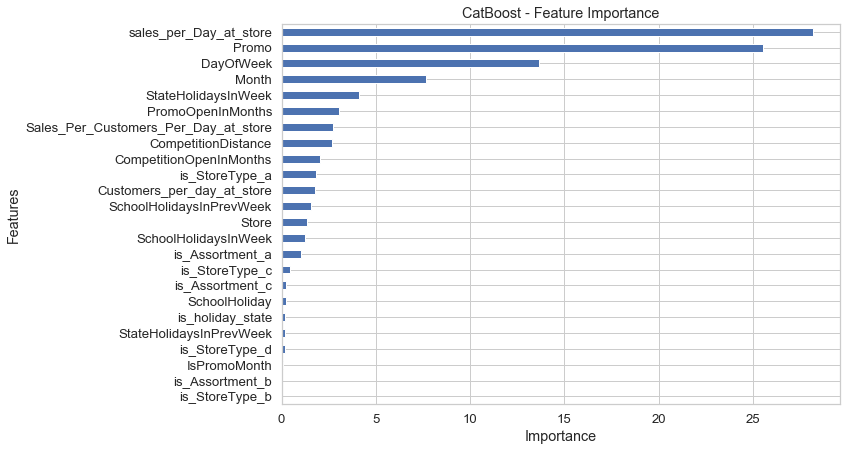

In [151]:
fea_imp = pd.DataFrame({'imp': cat_model.feature_importances_, 'col': train_store_features.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [152]:
fea_imp[['col','imp']].sort_values(by='imp',ascending=False)

,col,imp
5,sales_per_Day_at_store,28.19
2,Promo,25.55
1,DayOfWeek,13.63
8,Month,7.66
12,StateHolidaysInWeek,4.10
14,PromoOpenInMonths,3.02
7,Sales_Per_Customers_Per_Day_at_store,2.73
4,CompetitionDistance,2.67
13,CompetitionOpenInMonths,2.05
20,is_StoreType_a,1.81


In [153]:
#Prepraing submission
preds_val_cat = cat_model.predict(scaled_test_store_features)
pred_sales_cat= preds_val_cat
pred_sales_df_cat= pd.DataFrame({'Id': df_test_store['Id'], 
                          'Sales':pred_sales_cat })
pred_sales_df_cat.to_csv("submission_catboost.csv", index = False)

### 2.8.5 Time Series using FBProphet - An Alternative approach

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.


In [107]:
#FB Prophet
#Reading the train data again to avoid any confusion with the already prepared datasets above
#I will show the time series only for one store at the moment otherwise it will be all crunched up here.
# The way I will forecast for one store, similarly we can model for all other stores as well at once.
# Just forthe ease of explaining here and not over populating charts and forecasts, I shall be using one example
# StoreTypA-817

train_proph = pd.read_csv('train.csv', 
                       parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

# remove closed stores and those with no sales
train_proph = train_proph[(train_proph['Open'] != 0) & (train_proph['Sales'] != 0)]

# sales for the store number 817 (StoreType A)
sales_proph = train_proph[train_proph.Store == 817].loc[:, ['Date', 'Sales']]

sales_proph = sales_proph.rename(columns = {'Date': 'ds',
                                      'Sales': 'y'})
sales_proph.head()

,ds,y
816,2015-07-31,23093
1931,2015-07-30,22177
3046,2015-07-29,21556
4161,2015-07-28,23248
5276,2015-07-27,23932


In [108]:
sales_proph.shape

(784, 2)

In [109]:
# reverse to the order: from 2013 to 2015 in order to put the right timeline so that the next 6 weeks can be predicted well
sales_proph = sales_proph.sort_index(ascending = False)
sales_proph =sales_proph[['ds','y']]
print ("Shape of the sales dataset is {}".format(colored(sales_proph.shape,'red')))
print('*'*50 + '\n')
sales_proph.info()


Shape of the sales dataset is (784, 2)
**************************************************

<class 'pandas.core.frame.DataFrame'>
Int64Index: 784 entries, 1015796 to 816
Data columns (total 2 columns):
ds    784 non-null datetime64[ns]
y     784 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 18.4 KB


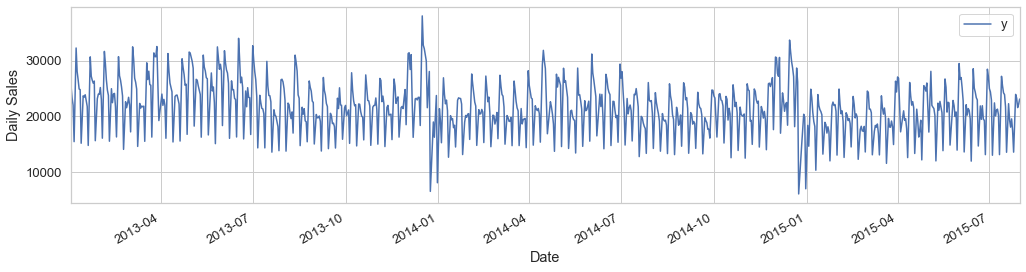

In [110]:
# plot daily sales
ax = sales_proph.set_index('ds').plot(figsize = (17, 4))
ax.set_ylabel('Daily Sales')
ax.set_xlabel('Date')
plt.show()


**Next important step if to model holidays in Prophet**

Prophet allows us to model custom holidays into the built prophet model. Also, we can add seasonality, etc.

We can also implement Built-in Country Holidays or Custom seasonalities with Prophet but as we don't know which country this Store belongs to, makes it difficult to achieve that task. Hence I will only model the holidays as per the store closed dates


In [111]:
# Let's select the two different types of holidays from our dataset
state_hol_dates = train_proph[(train_proph.StateHoliday == 'a') | (train_proph.StateHoliday == 'b') & (train_proph.StateHoliday == 'c')].loc[:, 'Date'].values
#assuming SchoolHoliday =1 means that there is a holiday
school_hol_dates = train_proph[df_train_ts.SchoolHoliday == 1].loc[:, 'Date'].values

state_hol = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_hol_dates)})
school_hol = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_hol_dates)})

holidays_total = pd.concat((state_hol, school_hol))      
holidays_total.head()


,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [112]:
%%time
from fbprophet import Prophet
# Setting uncertainity level to 95%. We have added holidays parameter here
model_fb_proph = Prophet(interval_width = 0.95, holidays = holidays_total)
model_fb_proph.fit(sales_proph)

# dataframe that extends into future 6 weeks 
future_pred_dates = model_fb_proph.make_future_dataframe(periods = 6*7)

print("Test output - First week forecast")
future_pred_dates.tail(7)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Test output - First week forecast
CPU times: user 1min 26s, sys: 495 ms, total: 1min 27s
Wall time: 1min 32s


,ds
819,2015-09-05
820,2015-09-06
821,2015-09-07
822,2015-09-08
823,2015-09-09
824,2015-09-10
825,2015-09-11


In [113]:
# predictions
forecast = model_fb_proph.predict(future_pred_dates)


In [114]:
# preditions for last week
prophet_pred = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
prophet_pred.head().append(prophet_pred.tail(7))
prophet_pred.shape


(826, 4)

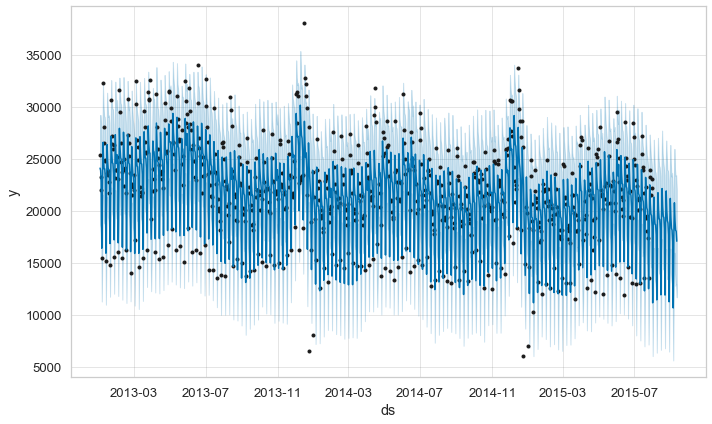

In [115]:
# visualizing predicions
model_fb_proph.plot(forecast);


Prophet successfully caught the trends and have got the values correctly, for most of the instances

Below we will see the forecast components that can correctly tell us that how our predictions went. This can help reveal how daily, weekly and yearly patterns of the time series including holidays contribute to the overall forecasted values

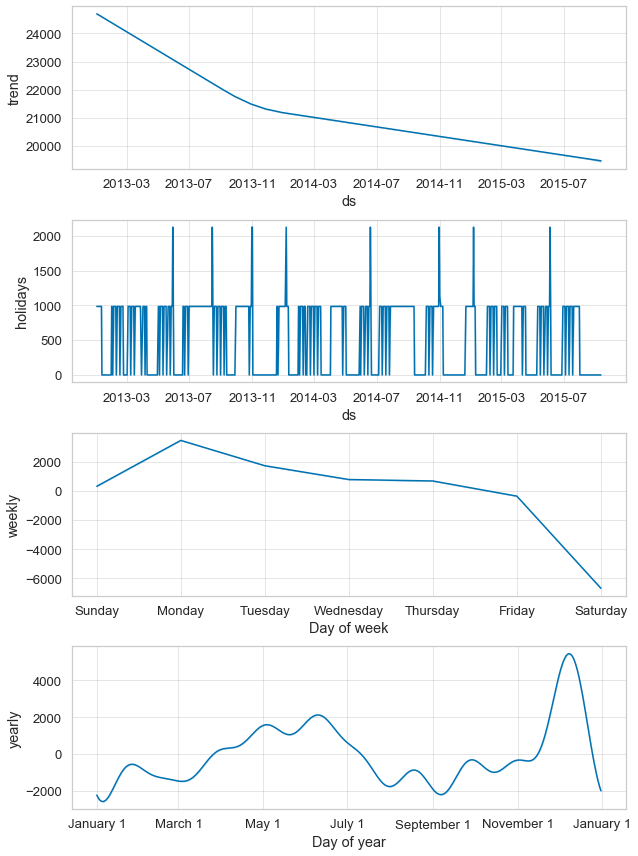

In [116]:
#Visualise different components of the forecasts
model_fb_proph.plot_components(forecast);


**What can we infer from above plots:**
1. The first plot shows that the monthly sales of store number 1 have been linearly decreasing over time.
2. The second shows the holidays gaps included in the model.
3. The third plot highlights the fact that the weekly volume of last week's sales peaks towards the Monday of the next.
4. The fourth plot shows that the busiest season occurs during the Christmas holidays.

#### Some takeaways from FBProphet
From above, it is clear that how we have used Prophet to produce results for one store, we could have similarly predicted the store sales for all the stores at once as well.

Just to not crunch up this space and complicate everything, I haven't done that. 
We can use the same code and remove the "Store Number filter" and train the model on all of the data at once and hence predict the next 6 weeks.

The best thing here is that without knowing which country the stores are in, I was still able to program the holiday's basis the dates when the stores were closed. This always improves a time series model.


In [ ]:
#I could have performed the CV using the built model, but being conscience of time, I will just show the code here and not run it on the entire

# from fbprophet.diagnostics import cross_validation
# df_cv = cross_validation(model_fb_proph, horizon = '7 days')

#Model performace done through- MAPE, MSE, RMSE
# from fbprophet.diagnostics import performance_metrics
# df_p = performance_metrics(df_cv)
# df_p.head()

**End of The Task!**

**Thank you!**